In [1]:
%matplotlib inline

# Adversarial Examples for cifar10

The net is implemented in `utils` and taken from [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-download-beginner-blitz-cifar10-tutorial-py](here). Some code is also taken from there.

Let's start with some simple image visualization.

Files already downloaded and verified
Files already downloaded and verified


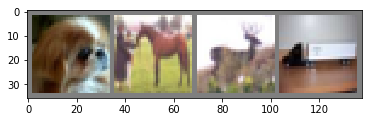

  dog horse  deer truck


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from cifar10_utils import *

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let's lode a network trained on cifar10.

In [4]:
net = Net()
net.load("cifar10net")
accuracy = net.accuracy(testloader)
print("Accuracy:", accuracy)

Accuracy: 0.5268


And now we can generate some adversarial examples.

Make everything a  ship
Initially:
GroundTruth:    dog horse  deer truck


/Users/nielswarncke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


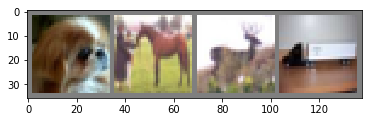

Predicted:  ['cat', 'horse', 'plane', 'plane']


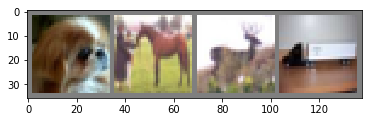

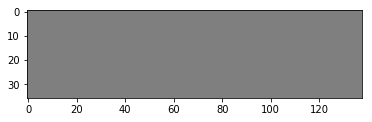

Predicted Adversarial:  ['cat', 'horse', 'plane', 'plane']
Finally:
Accuracy: 1.0
GroundTruth:    dog horse  deer truck


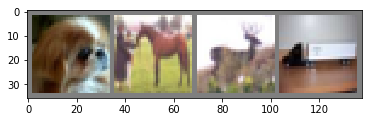

Predicted:  ['cat', 'horse', 'plane', 'plane']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


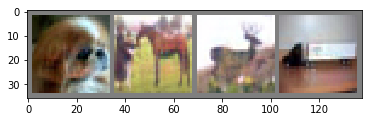

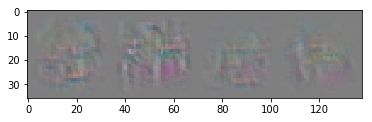

Predicted Adversarial:  ['ship', 'ship', 'ship', 'ship']


In [5]:
import random

def one_hot(labels):
    return torch.from_numpy(np.eye(10)[labels]).float()

def acc(outputs, labels):
    return np.mean(outputs.detach().numpy().argmax(axis=1) == labels)

def copy(images):
     return torch.tensor(images, requires_grad=True)
    
def predicted(inputs):
    return [classes[j] for j in net.forward(inputs).detach().numpy().argmax(axis=1)]
    
def plot_ae(images, adversarial):
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    imshow(torchvision.utils.make_grid(images.detach()))
    print('Predicted: ', predicted(images))
    imshow(torchvision.utils.make_grid(adversarial.detach()))
    imshow(torchvision.utils.make_grid((adversarial-images).detach()))
    print('Predicted Adversarial: ', predicted(adversarial))
    
# Adversarial noise:
def adversarial_noise(net, images, target_class, lr=0.01, plot_steps=False):
    noise = torch.zeros_like(images)
    outputs = net.forward(images)
    N = images.shape[0]
    target_classes = [target_class]*N
    adversarial = copy(images)
    adversarial.requires_grad_(True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD([adversarial], lr=lr, momentum=0.5)

    print("Make everything a ", classes[target_class])

    def step():
        optimizer.zero_grad()
        outputs = net.forward(adversarial)
        loss = criterion(outputs, torch.Tensor(target_classes).long())
        loss.backward()
        optimizer.step()

    applied = 0 
    print("Initially:")
    plot_ae(images, adversarial)
    while acc(net.forward(adversarial), target_classes)!=1:
        step()
        applied += 1
        if applied % 100 == 0 and plot_steps:
            print("Accuracy:", acc(net.forward(adversarial), target_classes))
            plot_ae(images, adversarial)
    print("Finally:")
    print("Accuracy:", acc(net.forward(adversarial), target_classes))
    plot_ae(images, adversarial)
    
    return (adversarial - images).detach()

an = adversarial_noise(net, images, random.randint(0,9))